In [1]:
using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
include("intro.jl")

using GraphPlot

Currently active project is: HN_V2

Path of active project: /Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2

Have fun with your new project!

You can help us improve DrWatson by opening
issues on GitHub, submitting feature requests,
or even opening your own Pull Requests!



In [2]:
function get_HN_graph(images ::Vector{Matrix{Int}},
                                scale ::Float64) ::SimpleWeightedGraph
    part_data = vec(images[1]) # Column major vector, columns are coancenated one after the other
    # part data only used to determine the number of entries in matrix
    # We assume that all images are of the same dimension here
    graph_set = SimpleWeightedGraph(length(part_data))
        
    for og in range(1,length(part_data) - 1)
        for term in range(og+1,length(part_data))
            # EDIT HERE, i is origin, j is end. We need to do this multiplication for every image
            # og and term give the values of column major, but that should not affect anything
            w = 0
            for i in images
                w += i[og] * (i[term]) / 1
            end
            add_edge!(graph_set, og, term, w)
        end
    end
    return graph_set
end

get_HN_graph (generic function with 1 method)

In [3]:
function save_trajectories(traj_collection::Vector{Vector{Hybrid}},
                           prefix::String,
                           suffix::String)
    # Save the trajectories in the Spin Reader format
    # traj_collection is a collection of trajectories collected after
    # agitations. We save each agitation in a separate file.
    for (ind, traj) in enumerate(traj_collection)
        out_file_name = prefix * "_$(ind)_" * suffix * ".dat"
        open(out_file_name, "w") do outf
            for (t, state) in enumerate(traj)
                print(outf, "$t")
                for (s, x) in zip(state[1], state[2])
                    print(outf, " $s $x")
                end
                println(outf, "")
            end
        end
        println("File $out_file_name is generated")
    end
    
end

save_trajectories (generic function with 1 method)

# IMAGES

In [202]:
#= template

image = [
    1 1 1 1 1;
    1 1 1 1 1;
    1 1 1 1 1;
    1 1 1 1 1;
    1 1 1 1 1;
] 
=#
i1 = [
    -1 1 1 1 -1;
    1 -1 1 -1 1;
    1 1 -1 1 1;
    1 -1 1 -1 1;
    -1 1 1 1 -1;
] 

i2 = [
    1 1 -1 1 1;
    1 1 -1 1 1;
    -1 -1 -1 -1 -1;
    1 1 -1 1 1;
    1 1 -1 1 1;
] 

i3 = [
    1 -1 1 -1 1;
    -1 -1 -1 -1 -1;
    1 -1 1 -1 1;
    -1 -1 -1 -1 -1;
    1 -1 1 -1 1;
] 

5×5 Matrix{Int64}:
  1  -1   1  -1   1
 -1  -1  -1  -1  -1
  1  -1   1  -1   1
 -1  -1  -1  -1  -1
  1  -1   1  -1   1

In [203]:

# Take image matrix and turn it into a vector with the rows being coancenated at their endpoints
# ex: [row1,row2,row3]

sim_time = 10
steps = 1500
parameters = Dict{String, Any}(
    "images" => [i1,i2,i3],
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 1, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => [(2,2,-1), (2,3,-1), (2,4,-1)]
)

Dict{String, Any} with 8 entries:
  "images"          => [[-1 1 … 1 -1; 1 -1 … -1 1; … ; 1 -1 … -1 1; -1 1 … 1 -1…
  "scaling"         => 1.0
  "iterations"      => 1
  "steps"           => 1500
  "num_agitations"  => 1
  "initial_stimuli" => [(2, 2, -1), (2, 3, -1), (2, 4, -1)]
  "sim_time"        => 10
  "delta"           => -0.00666667

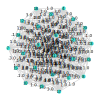

In [204]:
# Graph Checker
graph = get_HN_graph(parameters["images"],1.0)

elabels = [weights(graph)[e.src, e.dst] for e in edges(graph)]

# Plot with edge labels
gplot(graph, 
      nodelabel=1:nv(graph), 
      edgelabel=round.(elabels, digits=2),)

In [205]:
# Just gets raw result, no visualizer

scaling = parameters["scaling"]
    S = parameters["images"]
    time_total= parameters["sim_time"]
    steps = parameters["steps"]

    # Make Graph
    graph_set = get_HN_graph(S, scaling)
    
    # Making model
    # Stop time in model units
    total_time = time_total
    # Number of timesteps
    num_steps = steps
    # Step size
    delta_t = total_time/num_steps
    # Makes model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)

    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0
    counts_list = zeros(parameters["num_agitations"])

    for _ in 1:parameters["iterations"]
        pinned::Vector{Tuple{Int64, Int8}} = []
        state::Dice.Hybrid = Dice.get_random_hybrid(num_vertices, 2.0)
        #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
        for stim in parameters["initial_stimuli"]
            # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
            # Adding 1 will bring you to the first entry in the column and so on for +k
            pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
            state[1][pos] = stim[3]
            push!(pinned, (pos, stim[3]))
        end
        #println(state[1])
        agnum = 0
        for _ in 1:parameters["num_agitations"]
            agnum += 1
            println(agnum)
            state = Dice.propagate_pinned(model.graph, num_steps, parameters["delta"], model.coupling, state, pinned)
            # Comment out the other part of the or conditional to ignore negative images
            if (reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
            -1 .*reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                converged += 1
                break
            end
            state = (state[1], Dice.get_random_cube(num_vertices, 2.0))
        end
        counts_list[agnum] += 1
        global sol = state[1]
        global con = converged 
    end

pretty_table(reshape(sol,size(parameters["images"][1],1),size(parameters["images"][1],1)))
print(con)

1
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
└────────┴────────┴────────┴────────┴────────┘
1

# Trajectories

In [232]:
# Just gets raw result, no visualizer

scaling = parameters["scaling"]
    S = parameters["images"]
    time_total= parameters["sim_time"]
    steps = parameters["steps"]
    selector = 5

    # Make Graph
    graph_set = get_HN_graph(S, scaling)
    
    # Making model
    # Stop time in model units
    total_time = time_total
    # Number of timesteps
    num_steps = steps
    # Step size
    delta_t = total_time/num_steps
    # Makes model
    model = Dice.Model(graph_set, Dice.model_2_hybrid_coupling, delta_t)

    # Making randomized initial state
    num_vertices = Graphs.nv(model.graph)
    
    converged = 0
    diverged = 0
    counts_list = zeros(parameters["num_agitations"])

    for _ in 1:parameters["iterations"]
        traj_collection::Vector{Vector{Dice.Hybrid}} = []
        out_traj_name_prefix = "$(selector)x$(selector)-trajectories_len$(length(parameters["images"]))_t3"
        regular_suffix = "regular"
        fail_suffix = "failed"
        pinned::Vector{Tuple{Int64, Int8}} = []
        state::Dice.Hybrid = Dice.get_random_hybrid(num_vertices, 2.0)
        #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
        for stim in parameters["initial_stimuli"]
            # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
            # Adding 1 will bring you to the first entry in the column and so on for +k
            pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
            state[1][pos] = stim[3]
            push!(pinned, (pos, stim[3]))
        end
        #println(state[1])
        agnum = 0
        for _ in 1:parameters["num_agitations"]
            agnum += 1
            println(agnum)
            traj = Dice.trajectories_pinned(model.graph, num_steps, parameters["delta"], model.coupling, state, pinned)
            push!(traj_collection, traj)
            state = traj[end]
            # Comment out the other part of the or conditional to ignore negative images
            if (reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"] ||
            -1 .*reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in parameters["images"])
                println("GOOD")
                converged += 1
                break
            end
            state = (state[1], Dice.get_random_cube(num_vertices, 2.0))
        end
        pretty_table(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
        save_trajectories(traj_collection,
                  out_traj_name_prefix,
                "f")
        counts_list[agnum] += 1
        global sol = state
        global con = converged 
    end

print(con)

1
GOOD
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
└────────┴────────┴────────┴────────┴────────┘
File 5x5-trajectories_len3_t3_1_f.dat is generated
1

In [207]:
println(sol)
pretty_table(reshape(sol[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))

(Int8[1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1], [-0.15478818289738158, 0.02210440449440726, 0.003236963073231666, -0.1413538375057935, -0.17215908015321318, -0.15480979573564063, 0.0, -0.08234658811909405, 0.16236095902664754, -0.07852374317065595, 0.0014076632284352741, 0.0, 0.008862132398055056, -0.20111238389903185, 0.06303167057761849, -0.03732402051590024, 0.0, -0.0558083900136041, 0.025025923315441276, 0.058654161484406026, -0.11583727781321246, -0.023618590313142965, 0.012016168676824271, -0.12309871293027405, -0.20283056703823005])
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
└────────┴────────┴────────┴

# TESTING ROTATIONS

In [208]:
function hybrid_to_cont_TEST(hybrid::Hybrid, r::Float64=0.0)::Array{Float64}
    return hybrid[2] .+ hybrid[1] .+ r
end

hybrid_to_cont_TEST (generic function with 2 methods)

In [209]:
function realign_hybrid_TEST(conf::Hybrid, r=0.0)::Hybrid
    # Changes the reference point for the separated representation by `r`
    # Rotates by -r, so if x = 0 then rotated by r would yield x = -r
    # according to xi - r = sigma(r) + X(r)
    # INPUT & OUTPUT:
    #     conf = (sigma, X)
    V = hybrid_to_cont_TEST(conf, 0.0)
    return Dice.cont_to_hybrid(V, r)
end

realign_hybrid_TEST (generic function with 2 methods)

In [210]:
# For 2 images, i1 and i2. Origin file in len2_t2_1_test

sol_rotate = sol;
rotated = realign_hybrid_TEST(sol_rotate, 0.0)
pretty_table(reshape(-1 .* rotated[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))

┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
└────────┴────────┴────────┴────────┴────────┘


In [238]:
sol_rotate = sol;
r = 0.0
println("ORIGINAL")
println(sol[2][1])
pretty_table(reshape(sol_rotate[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
rotated = realign_hybrid_TEST(sol_rotate,r)
println("ROTATED BY $r")
println(rotated[2][1])
pretty_table(reshape(rotated[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
if sol_rotate[1] == rotated[1]
    println("Same")
else 
    println("Diff")
end

ORIGINAL
-0.17114645794854436
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
└────────┴────────┴────────┴────────┴────────┘
ROTATED BY 0.0
-0.17114645794854422
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
│     -1 │     -1 │     -1 │     -1 │     -1 │
│      1 │     -1 │      1 │     -1 │      1 │
└────────┴────────┴────────┴────────┴────────┘
Same


In [241]:
# Checks if any rotations of the circle yeild a valid, positive image
sol_rotate = sol
im_f = 0
rot_vals = collect(range(-2, 2, 10))
image_list = parameters["images"]

if !(0 in rot_vals)
    push!(rot_vals, 0)
    sort!(rot_vals)
end


for disp in rot_vals
    rotated = realign_hybrid_TEST(sol_rotate,disp)
    M = reshape(rotated[1],size(parameters["images"][1],1),size(parameters["images"][1],1))
    println(disp)
    pretty_table(M)
    if reshape(rotated[1],size(parameters["images"][1],1),size(parameters["images"][1],1)) in image_list
        println("SOLUTION FOUND AT r = $(disp)")
        pretty_table(reshape(rotated[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
        im_f +=1
        
    end
end
println("$im_f Images Found")
    

-2.0
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
└────────┴────────┴────────┴────────┴────────┘
-1.5555555555555556
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼────────┼────────┼────────┼────────┤
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
│      1 │      1 │      1 │      1 │      1 │
│     -1 │      1 │     -1 │      1 │     -1 │
└────────┴────────┴────────┴────────┴────────┘
-1.1111111111111112
┌────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │
├────────┼─────